In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [3]:
def convert_gains(gain, bits_decimal = 8):
    '''
    Function to convert gain values from integer representation of multiples of 
    the ADC resolution to float
    '''
    resolution = 2**-8
    return -32+(gain-8192)*resolution if gain >=8192 else  gain*resolution

def get_plot_params(df):
    '''
    Extract median and std from shifts to create plot with shifts and 
    the respectives error bars
    '''
    filt_grouped = df.groupby('final_gain', as_index=False).agg(np.median)
    gains = filt_grouped['final_gain'].values
    median_shifts = filt_grouped['shift'].values
    std = df.groupby('final_gain').agg(np.std)['shift'].values
    return gains, median_shifts, std



def include_quartis(df):
    '''
    Include Q1 and Q3 values for each gain to remove outliers and 
    execute data cleaning
    '''
    q1 = df.groupby('gain', as_index=False).quantile(0.25)
    q1['shift_q1'] = q1['shift']
    q1 = q1.drop('shift', axis=1)
    df = pd.merge(df, q1[['gain', 'shift_q1']], on='gain')
    q3 = df.groupby('gain', as_index=False).quantile(0.75)
    q3['shift_q3'] = q3['shift']
    q3 = q3.drop('shift', axis=1)
    df = pd.merge(df, q3[['gain', 'shift_q3']], on='gain')
    df['diq'] = df['shift_q3'] - df['shift_q1']
    df['upper'] = df['shift_q3'] + 1.5*df['diq']
    df['bottom'] = df['shift_q1'] - 1.5*df['diq']
    return df

In [4]:
df = pd.read_csv('../data/shift/data.csv', index_col=False)
df.head()

,gain,batch,omega,omega_ref
0,10394,0,80519.193286,80058.792346
1,10601,0,79652.248500,81345.428762
2,10824,0,80586.942211,81274.120058
3,11065,0,80608.286129,80792.427812
4,11332,0,80649.449494,80750.302388


In [5]:
df = df[~df['gain'].isin([7388, 8000, 8384, 9000])]
df['shift'] = df['omega'] - df['omega_ref']
df = include_quartis(df)
df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
df['gain'] = df['gain'].apply(convert_gains)
df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['gain'].values,3)
df = df.sort_values(by=['final_gain'])

filt_df = df[(df['final_gain']>-2e6)&(df['final_gain']<2e6)]
out_of_perturbation = df[(df['final_gain']<-2e6)|(df['final_gain']>2e6)] 
filt_df = df.copy()
gains, median_shifts, std = get_plot_params(filt_df)
gains_pert, median_shifts_pert, std_pert = get_plot_params(out_of_perturbation)

X = filt_df['final_gain'].values.reshape((-1,1))
y = filt_df['shift'].values

In [6]:
model = LinearRegression().fit(X, y)
r_sq = model.score(X, y)
model.coef_

array([-0.00051795])

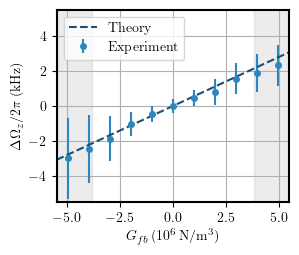

In [8]:
gain_linspace = np.linspace(1.4*df['final_gain'].values.min(), 
                    1.4*df['final_gain'].values.max(), 100)   
y = model.coef_*gain_linspace + model.intercept_
delta_f = -0.000558736548199816 
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4, 4.2))
fig.set_size_inches(3, 2.5, forward=True)
plt.plot(gain_linspace/1e6, -gain_linspace*delta_f/1e3, linestyle='--', color=colors[2])
plt.ylim([-5.5, 5.5])
plt.xlim([-5.5, 5.5])
plt.errorbar(gains[::5]/1e6, -median_shifts[::5]/1e3, yerr=std[::5]/1e3, 
                fmt='o', color=colors[0], markersize=4)   
plt.grid()
plt.xlabel(r'$G_{fb} \,(10^6\, \textrm{N/m}{}^3)$')
plt.ylabel(r'$\Delta \Omega_z/2\pi$ (kHz)')
plt.legend(['Theory', 'Experiment'], fontsize=10)
plt.fill_between([-5.5, -3.83], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
plt.fill_between([3.83, 5.5], [6e3, 6e3], [-6e3, -6e3], color='gray', alpha=0.15)
plt.savefig('../plots/test_shift.pdf', bbox_inches='tight')
plt.show()

In [ ]:
rho=2200
R = 150e-9/2
m = rho*np.pi*4*R**3/3
kb = 1.38e-23
omega = 2*np.pi*8.5e4
T = 273+22
gamma = 13578.7501
m*m*gamma*omega**3/(2*kb*T)/1e6

3.839858674559637

In [7]:
df = pd.read_csv('../data/shift/data.csv', index_col=False)
df['shift'] = df['omega'] - df['omega_ref']

df = include_quartis(df)
print('Total length of dataset - {}'.format(len(df)))
print(df['gain'].unique())
df = df[(df['shift']>df['bottom'])&(df['shift']<df['upper'])]
print('Total length of FILTERED dataset - {}'.format(len(df)))
df['final_gain'] = df['gain'].apply(convert_gains)
# remove gains that are not in the step and were taken in the first measure
df['final_gain'] = 11.27*3.03e-15*np.power(-11*1.504e4*df['final_gain'].values,3)


Total length of dataset - 10988
[10394 10601 10824 11065 11332 11630 11971 12374 12881 13604     0  2780
  3503  4010  4413  4754  5052  5319  5560  5783  5990  7388  8000  8384
  9000  6183  6365  6537  6700  6856  7005  7149  7286  7419  7546  7670
  7790  7906  8019  8129 10200 10018  9846  9683  9527  9378  9234  9097
  8964  8837  8713  8593  8477  8364  8254]
Total length of FILTERED dataset - 10711


In [8]:
df['gain'].unique()

array([10394, 10601, 10824, 11065, 11332, 11630, 11971, 12374, 12881,
       13604,     0,  2780,  3503,  4010,  4413,  4754,  5052,  5319,
        5560,  5783,  5990,  7388,  8000,  8384,  9000,  6183,  6365,
        6537,  6700,  6856,  7005,  7149,  7286,  7419,  7546,  7670,
        7790,  7906,  8019,  8129, 10200, 10018,  9846,  9683,  9527,
        9378,  9234,  9097,  8964,  8837,  8713,  8593,  8477,  8364,
        8254])

In [9]:
stats.shapiro(df[df['gain']==2780]['shift'].values[::5])

ShapiroResult(statistic=0.9766166806221008, pvalue=0.5978496074676514)

In [16]:
def gaussian_plot_params(df, gain):
    sub_df = df[df['gain']==gain]
    mean = sub_df['shift'].values.mean()
    std = sub_df['shift'].values.std()
    final_gain = sub_df['final_gain'].values[0]
    return mean, std, final_gain

In [17]:
len(df['batch'].unique())

200